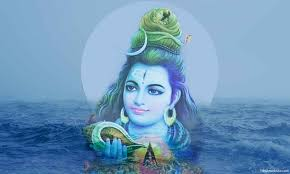

In [19]:
from IPython.display import Image, display
Image('shiva.jpg')

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import PIL.Image
import matplotlib.pyplot as plt
%matplotlib inline

import torchvision.transforms as transforms
import torchvision.models as models

import copy

import numpy as np
import random
import math
from scipy.ndimage.filters import gaussian_filter

In [21]:
device = torch.device("cpu")

In [22]:
# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 224  # use small size if no gpu

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor

In [23]:
def image_loader(image_name):
    image = PIL.Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

In [24]:
image = image_loader("shiva.jpg")

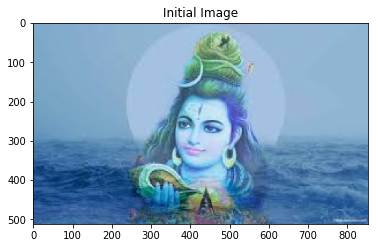

In [25]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(image, title='Initial Image')

In [26]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

In [27]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [28]:
cnn

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

In [29]:
class customCNN(nn.Module):
    def __init__(self, original_model):
        super(customCNN, self).__init__()
        self.features = nn.Sequential(*list(original_model.children())[:26])
        
    def forward(self, x):
        x = self.features(x)
        x = x.squeeze(0)
        x = x[44, :, :]
        return x

CNN = customCNN(cnn)

outputs = cnn(image)
print(outputs.data.shape)

outputs = CNN(image)
print(outputs.data.shape)

torch.Size([1, 512, 16, 26])
torch.Size([64, 106])


In [37]:
class My_Loss(nn.Module):

    def __init__(self, target_feature):
        super(My_Loss, self).__init__()
        self.target = target_feature
        self.loss = -1 * (sum(sum(self.target ** 2)) ** (0.5))
        
    def forward(self, input):
        self.loss = -1 * (sum(sum(self.target ** 2)) ** (0.5))
        return input

In [38]:
sum(sum(outputs.detach() ** 2)) ** (0.5)

tensor(194.3947)

In [39]:
def get_loss(img, CNN, normalization_mean, normalization_std):
    
    cnn = copy.deepcopy(CNN)
    
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    model = nn.Sequential(
          normalization,
          CNN
        )
    feature = model(img)
    myloss = My_Loss(feature)
    model.add_module("Loss_Layer", myloss)
    
    return model, myloss.loss

In [40]:
input_img = image.clone()

In [41]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [44]:
def deep_dream(input_img, cnn, normalization_mean, normalization_std, num_steps = 5):
    
    model, loss = get_loss(input_img, cnn, normalization_mean, normalization_std)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            print(loss)
            loss.backward(retain_graph=True)

            run[0] += 1

            return loss

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

In [45]:
output = deep_dream(input_img, CNN,  cnn_normalization_mean, cnn_normalization_std, num_steps=5)

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


Optimizing..
tensor(-229.4420, grad_fn=<MulBackward0>)
tensor(-229.4420, grad_fn=<MulBackward0>)
tensor(-229.4420, grad_fn=<MulBackward0>)
tensor(-229.4420, grad_fn=<MulBackward0>)
tensor(-229.4420, grad_fn=<MulBackward0>)
tensor(-229.4420, grad_fn=<MulBackward0>)
